# 영화 덧글 분석
---

## Colab 초기화

In [1]:
#!apt-get update -qq
#!apt-get install fonts-nanum* -qq
#! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
#! ls
#% cd Mecab-ko-for-Google-Colab
#! bash install_mecab-ko_on_colab190912.sh

## 1) 패키지 준비하기

In [1]:
from pandas import DataFrame
from pandas import read_excel
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
# 한글 형태소 분석
# -> window
from eunjeon import Mecab
# -> mac, linux(colab)
#from konlpy.tag import Mecab
#from konlpy.tag import Okt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## 2) 데이터셋 준비하기

In [2]:
df = read_excel('http://itpaper.co.kr/data/movie_review.xlsx', engine='openpyxl')
df

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,부정
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,긍정
2,너무재밓었다그래서보는것을추천한다,부정
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,부정
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,긍정
...,...,...
199995,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,긍정
199996,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,부정
199997,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,부정
199998,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,부정


## 3) 데이터 전처리

### 결측치 확인

In [12]:
df.isna().sum()

document    0
label       0
dtype: int64

### 한글과 공백을 제외하고 제거

In [13]:
# regex=True 파라미터를 지정하지 않을 경우 다음버전부터는 "regex=True" 가 필요하다는 경고 발생함
df['document'] = df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
df['document'].replace('', np.nan, inplace=True)
df.isnull().sum()

document    0
label       0
dtype: int64

### 결측치 삭제

In [14]:
df.dropna(inplace=True)
df.isna().sum()

document    0
label       0
dtype: int64

### 종속변수 레이블링

In [15]:
df['label'] = df['label'].replace({'긍정': 1, '부정': 0})
df['label'].unique()

array([0, 1], dtype=int64)

## 4) 탐색적 데이터 분석

### 긍정과 부정 비율 확인

In [16]:
df.groupby('label').count()

,document
label,
0,99398
1,99511


### 형태소 분석 객체 생성

In [17]:
mecab = Mecab()
morphs = mecab.morphs(df['document'][0])

#okt = Okt()
#morphs = okt.morphs(df['document'][10])
print(morphs)

['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리']


### 불용어 리스트 정의

분석에 포함시키지 않을 단어들 나열.

In [18]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '걍']

### 모든 데이터에 대해서 형태소 분석을 수행하고 불용어는 제거한 결과를 생성

In [11]:
word_set = []

for i, v in enumerate(df['document']):
    #morphs = okt.morphs(v)
    morphs = mecab.morphs(v)
    tmp_word = []
    for j in morphs:
        if j not in stopwords:
            tmp_word.append(j)
            
    word_set.append(tmp_word)
    
# 상위 3건만 출력해서 확인
word_set[:3]

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다']]

### 토큰화

단어집합 생성 및 인덱스 번호 부여

각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(word_set)
len(tokenizer.word_index)

56651

### 등장 빈도수가 3회 미만인 단어의 비중 확인

- 등장 빈도가 threshold 값인 3회 미만. 즉, 2회 이하인 단어들은 단어 집합에서 무려 절반 이상을 차지
- 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 4.3%
- 등장 빈도가 2회 이하인 단어들은 자연어 처리에서 별로 중요하지 않은 듯 
- 이 단어들은 정수 인코딩 과정에서 배제!!!

In [13]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 56651
등장 빈도가 2번 이하인 희귀 단어의 수: 31517
단어 집합에서 희귀 단어의 비율: 55.633616352756356
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.4541638195565423


### 단어 집합의 최대 크기 정의

- 등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한
- 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2

In [14]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 25136


### 텍스트 시퀀스를 숫자 시퀀스로 변환

산출된 단어 집합의 크기(vocab_size)를 케라스 토크나이저의 인자로 설정하여 텍스트 시퀀스를 숫자 시퀀스로 변환

-> 이보다 큰 숫자가 부여된 단어들은 OOV로 변환

In [15]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(word_set)
token_set = tokenizer.texts_to_sequences(word_set)
len(token_set)

198909

### 토큰화 결과를 json 파일로 저장

In [33]:
import json
with open("word_index.json", "w", encoding='utf-8') as f:
    json = json.dumps(tokenizer.word_index)
    f.write(json)

### 빈 샘플 찾기

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성된 리뷰는 이제 빈 샘플이 되었다는 것을 의미함.

빈 샘플은 의미가 없으므로 삭제하는 것이 성능 향상에 도움이 됨.

각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아온다.

In [16]:
drop_train = []

for i, v in enumerate(token_set):
    if len(v) < 1:
        drop_train.append(i)
        
len(drop_train)

617

### 빈 샘플 삭제

In [17]:
fill_token_set = np.delete(token_set, drop_train, axis=0)
len(fill_token_set)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


198292

### 레이블에 대해서도 해당 위치의 항목들 삭제

In [18]:
lables = np.delete(np.array(df['label']), drop_train)
len(lables)

198292

### 패딩

서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 작업.

여기서는 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 확인

리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 13.565156435963125


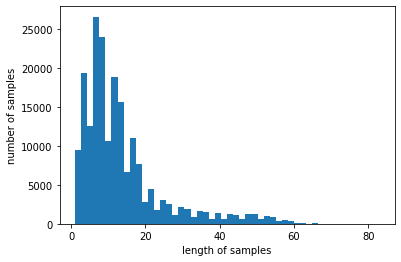

In [19]:
print('리뷰의 최대 길이 :',max(len(l) for l in fill_token_set))
print('리뷰의 평균 길이 :',sum(map(len, fill_token_set))/len(fill_token_set))
plt.hist([len(s) for s in fill_token_set], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
pad_token_set = pad_sequences(fill_token_set, maxlen=30)

## 5) 데이터셋 분할하기

### 랜덤시드 고정

In [21]:
np.random.seed(777)

### 훈련 데이터와 검증 데이터로 분할

In [22]:
x_train, x_test, y_train, y_test = train_test_split(pad_token_set, lables, test_size = 0.3, random_state = 777)
print("훈련용 데이터셋 크기: %d, 검증용 데이터셋 크기: %d" % (len(x_train),  len(x_test)))

훈련용 데이터셋 크기: 138804, 검증용 데이터셋 크기: 59488


## 6) 모델 개발

### 모델 정의

In [23]:
model = Sequential()

# input_dim의 크기는 토큰 생성시 지정한 최대 단어수(vocab_size)와 동일하게 설정
# output_dim의 크기는 input_dim보다 작은 값 중에서 설정
model.add(Embedding(input_dim = vocab_size, output_dim = 32))
model.add(GRU(128))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          804352    
_________________________________________________________________
gru (GRU)                    (None, 128)               62208     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 866,689
Trainable params: 866,689
Non-trainable params: 0
_________________________________________________________________


### 학습하기

In [24]:
result = model.fit(x_train, y_train, batch_size = 32, epochs = 30, validation_data=(x_test, y_test), callbacks = [
    ModelCheckpoint(filepath = 'check_point.h5', monitor = 'val_loss', verbose=1, save_best_only = True),
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

Epoch 1/30
4338/4338 [==============================] - 56s 13ms/step - loss: 0.4285 - acc: 0.7938 - val_loss: 0.3342 - val_acc: 0.8542

Epoch 00001: val_loss improved from inf to 0.33420, saving model to check_point.h5
Epoch 2/30
4338/4338 [==============================] - 61s 14ms/step - loss: 0.2873 - acc: 0.8806 - val_loss: 0.3272 - val_acc: 0.8578

Epoch 00002: val_loss improved from 0.33420 to 0.32725, saving model to check_point.h5
Epoch 3/30
4338/4338 [==============================] - 60s 14ms/step - loss: 0.2390 - acc: 0.9024 - val_loss: 0.3388 - val_acc: 0.8554

Epoch 00003: val_loss did not improve from 0.32725
Epoch 4/30
4338/4338 [==============================] - 57s 13ms/step - loss: 0.1979 - acc: 0.9225 - val_loss: 0.3549 - val_acc: 0.8538

Epoch 00004: val_loss did not improve from 0.32725
Epoch 5/30
4338/4338 [==============================] - 57s 13ms/step - loss: 0.1625 - acc: 0.9371 - val_loss: 0.3978 - val_acc: 0.8497

Epoch 00005: val_loss did not improve from 

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,0.377209,0.829429,0.334204,0.854206,0.0010
2,0.292028,0.877554,0.327247,0.857786,0.0010
3,0.246667,0.899196,0.338829,0.855383,0.0010
4,0.208110,0.917164,0.354865,0.853819,0.0010
5,0.172828,0.932459,0.397753,0.849667,0.0010
6,0.124630,0.952862,0.481908,0.845061,0.0005
7,0.104063,0.961500,0.541249,0.843027,0.0005


## 7) 학습 결과 평가

### 학습 결과 시각화

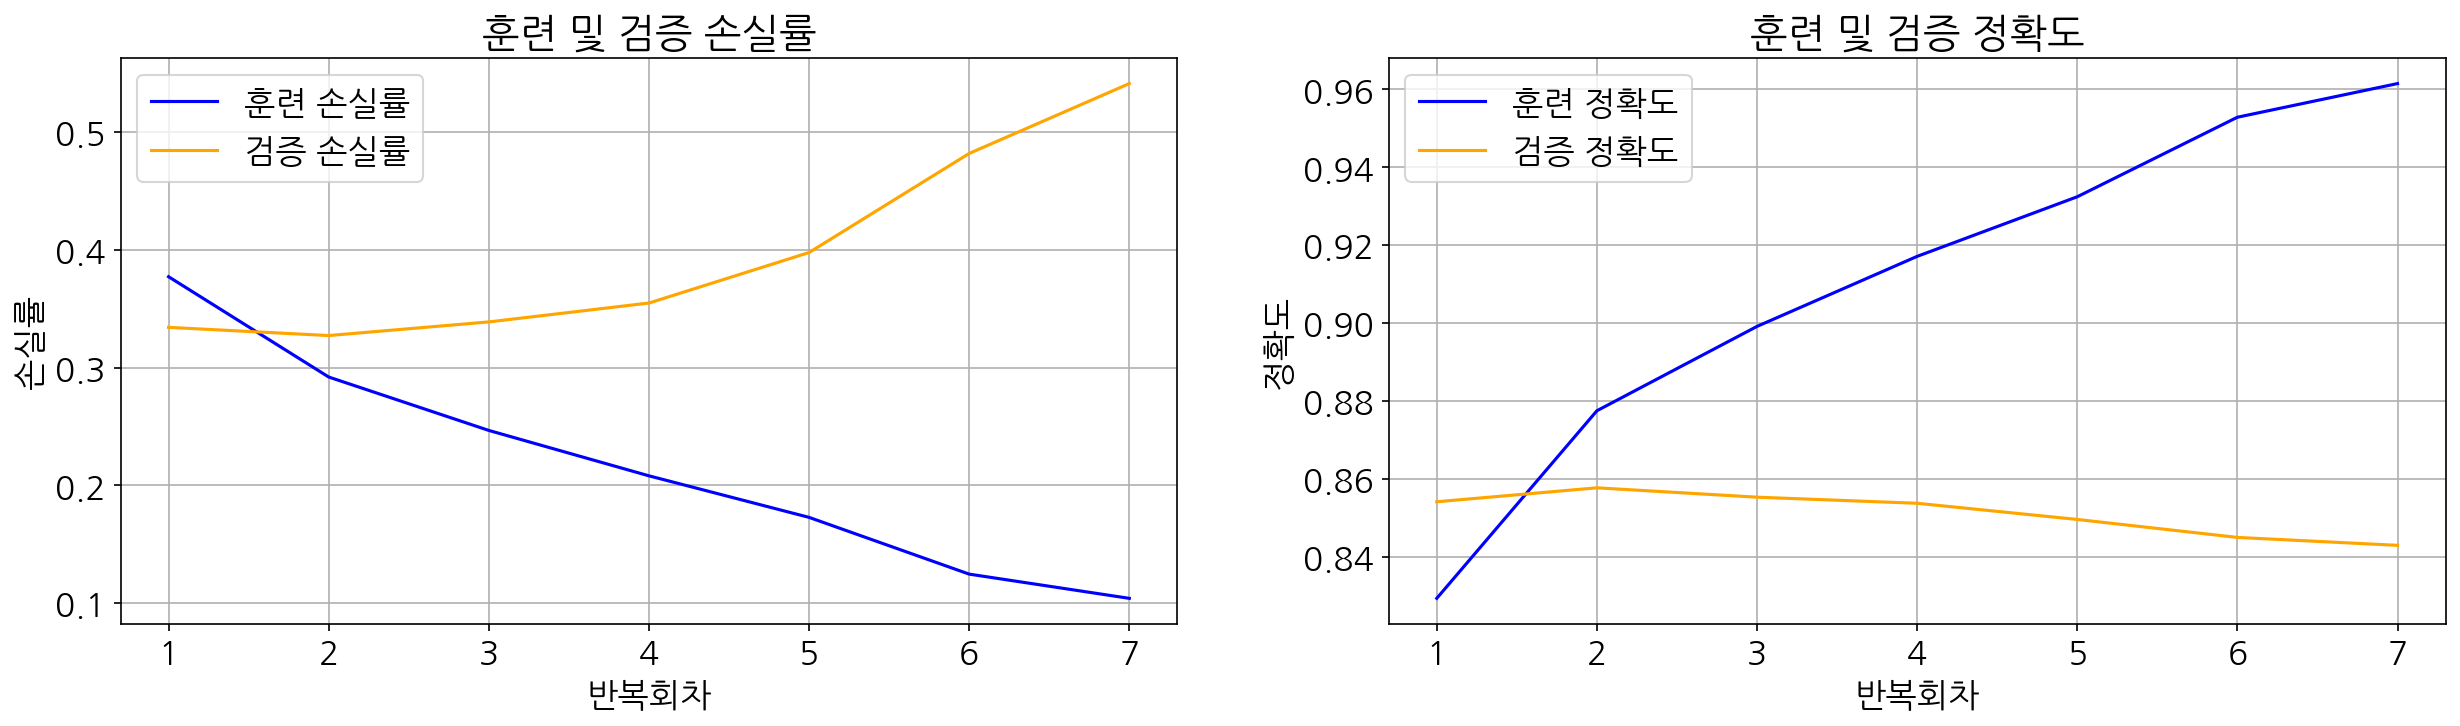

In [25]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sns.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='acc', data=result_df, color = 'blue', label = '훈련 정확도', ax=ax2)
sns.lineplot(x=result_df.index, y='val_acc', data=result_df, color = 'orange', label = '검증 정확도', ax=ax2)
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

#plt.savefig('result.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()

### 모델 성능 평가

In [26]:
evaluate = model.evaluate(x_test, y_test)
print("최종 손실률: %f, 최종 정확도: %f" % (evaluate[0], evaluate[1]))

1859/1859 [==============================] - 5s 3ms/step - loss: 0.5412 - acc: 0.8430
최종 손실률: 0.541249, 최종 정확도: 0.843027


## 8) 학습 결과 적용
---

### 테스트 데이터에 대한 예측 결과 산정

In [27]:
result = model.predict(x_test)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result[0]

59488개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([0.00041834], dtype=float32)

### 결과 데이터 셋 구성

In [28]:
kdf = DataFrame({
    '결과값': y_test,
    '예측치' : np.round(result.flatten())
})

kdf['예측치'] = kdf['예측치'].astype('int')
kdf

,결과값,예측치
0,1,0
1,1,1
2,1,1
3,0,0
4,1,1
...,...,...
59483,1,1
59484,1,0
59485,0,0
59486,0,0


### 오차행렬

실제 결과값과 머신러닝에 의한 예측값 비교

In [29]:
cm = confusion_matrix(kdf['결과값'], kdf['예측치'])
cmdf1 = DataFrame(cm, columns=['예측값(P)', '예측값(N)'], index=['실제값(T)', '실제값(F)'])
cmdf1

,예측값(P),예측값(N)
실제값(T),25381,4272
실제값(F),5066,24769


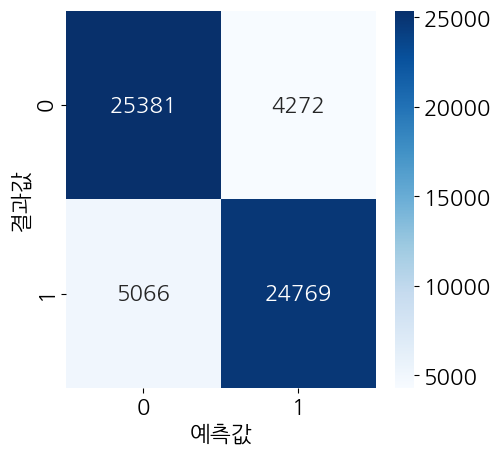

In [30]:
# --> 5를 분류할 때 가장 많이 혼란스러워 한다.
# --> 오차행렬은 모델의 강점과 약점을 파악하기에 유용하다.
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams["font.size"] = 16

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
# 오차 행렬을 히트맵 그래프로 표현
# -> annot : 그래프의 각 칸에 수치값 출력
# -> fmt : 수치값 출력 format (여기서는 10진수)
# -> cmap : 색상맵 (https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html)
sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues', ax=ax)
ax.set_xlabel('예측값')
ax.set_ylabel('결과값')
plt.show()
plt.close()